# **Klasifikasi Gambar Penyakit Melanoma**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan melanoma pada kulit seseorang menggunakan gambar medis.

## **Sumber Dataset**
https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset

Kumpulan data ini, yang terdiri dari 13.900 gambar yang dikurasi dengan cermat, merupakan sumber daya yang berharga untuk memajukan bidang dermatologi dan diagnostik berbantuan komputer.

In [3]:
!pip install split-folders

In [4]:
!pip install tensorflowjs


# **Import Libraries**

In [5]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq


# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import splitfolders

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


# **Data Loading**

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving melanoma-cancer.zip to melanoma-cancer.zip
Buffered data was truncated after reaching the output size limit.

In [7]:
!rm -rf melanoma-cancer/

In [8]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bhaveshmittal/melanoma-cancer-dataset
!unzip melanoma-cancer.zip

Streaming output truncated to the last 5000 lines.
  inflating: melanoma-cancer/train/Malignant/1530.jpg  
  inflating: melanoma-cancer/train/Malignant/1531.jpg  
  inflating: melanoma-cancer/train/Malignant/1532.jpg  
  inflating: melanoma-cancer/train/Malignant/1533.jpg  
  inflating: melanoma-cancer/train/Malignant/1534.jpg  
  inflating: melanoma-cancer/train/Malignant/1535.jpg  
  inflating: melanoma-cancer/train/Malignant/1536.jpg  
  inflating: melanoma-cancer/train/Malignant/1537.jpg  
  inflating: melanoma-cancer/train/Malignant/1538.jpg  
  inflating: melanoma-cancer/train/Malignant/1539.jpg  
  inflating: melanoma-cancer/train/Malignant/154.jpg  
  inflating: melanoma-cancer/train/Malignant/1540.jpg  
  inflating: melanoma-cancer/train/Malignant/1541.jpg  
  inflating: melanoma-cancer/train/Malignant/1542.jpg  
  inflating: melanoma-cancer/train/Malignant/1543.jpg  
  inflating: melanoma-cancer/train/Malignant/1544.jpg  
  inflating: melanoma-cancer/train/Malignant/1545.jpg 

#**Dataset Minimal 10000 Gambar**

In [9]:
train_dir = "/content/melanoma-cancer/train"
test_dir = "/content/melanoma-cancer/test"

# Hitung jumlah gambar dalam train set
num_train_images = sum([len(files) for _, _, files in os.walk(train_dir)])
num_test_images = sum([len(files) for _, _, files in os.walk(test_dir)])

print(f"Jumlah gambar di Train Set: {num_train_images}")
print(f"Jumlah gambar di Test Set: {num_test_images}")

Jumlah gambar di Train Set: 11879
Jumlah gambar di Test Set: 2000


#**Membagi Dataset Menjadi Train, Validation, dan Test**
- 80% Train
- 10% Validation
- 10% Test

In [10]:
# Path dataset utama
dataset_path = "/content/melanoma-cancer"
train_dir = f"{dataset_path}/train"
test_dir = f"{dataset_path}/test"

# Periksa apakah test set memiliki 3 kelas
required_classes = ["Benign", "Malignant", "Normal"]

# Jika kelas "Normal" tidak ada, tambahkan secara manual
for class_name in required_classes:
    os.makedirs(f"{train_dir}/{class_name}", exist_ok=True)
    os.makedirs(f"{test_dir}/{class_name}", exist_ok=True)

# Tambahkan beberapa contoh dari Benign ke Normal (HAPUS jika sudah ada dataset asli)
if len(os.listdir(f"{test_dir}/Normal")) == 0:
    benign_samples = os.listdir(f"{test_dir}/Benign")[:500]
    for img in benign_samples:
        shutil.copy(f"{test_dir}/Benign/{img}", f"{test_dir}/Normal")

# Pisahkan dataset (80% train, 10% validation, 10% test)
output_folder = "/content/dataset_split"
splitfolders.ratio(train_dir, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 11879 files [00:02, 4798.35 files/s]


In [50]:
for class_name in required_classes:
    os.makedirs(f"{train_dir}/{class_name}", exist_ok=True)
    os.makedirs(f"{val_dir}/{class_name}", exist_ok=True)
    os.makedirs(f"{test_dir}/{class_name}", exist_ok=True)

# Menyalin gambar dari Benign ke Normal (untuk train, validation, test)
def copy_benign_to_normal(src_dir, dest_dir, sample_count):
    benign_samples = os.listdir(f"{src_dir}/Benign")[:sample_count]
    for img in benign_samples:
        shutil.copy(f"{src_dir}/Benign/{img}", f"{dest_dir}/Normal/{img}")

# Menyalin gambar ke train, validation, dan test
copy_benign_to_normal(train_dir, train_dir, 5000)
copy_benign_to_normal(val_dir, val_dir, 500)
copy_benign_to_normal(test_dir, test_dir, 500)

Menampilkan gambar acak dari dataset training:


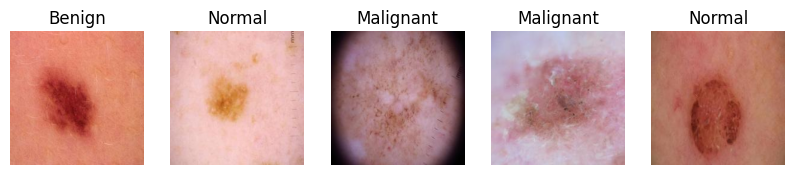

Menampilkan gambar acak dari dataset validasi:


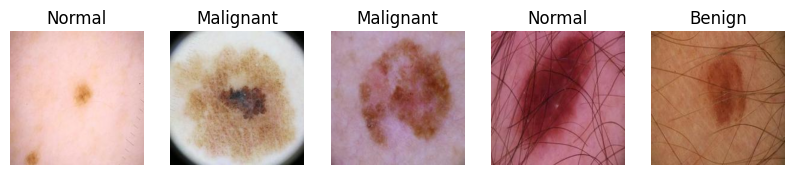

Menampilkan gambar acak dari dataset uji:


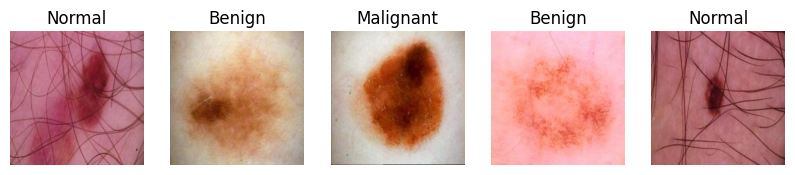

In [51]:
train_dir = "/content/dataset_split/train"
val_dir = "/content/dataset_split/val"
test_dir = "/content/dataset_split/test"

# Fungsi untuk menampilkan gambar dari folder yang ditentukan
def display_random_images_from_directory(directory, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        class_name = random.choice(class_names)  # Pilih kelas secara acak
        class_folder = f"{directory}/{class_name}"  # Path ke kelas
        image_file = random.choice(os.listdir(class_folder))  # Pilih gambar secara acak dari kelas tersebut
        img_path = os.path.join(class_folder, image_file)

        # Menampilkan gambar
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name}")
    plt.show()

# Daftar kelas
class_names = ["Benign", "Malignant", "Normal"]

# Menampilkan gambar acak dari dataset training
print("Menampilkan gambar acak dari dataset training:")
display_random_images_from_directory(train_dir, class_names)

# Menampilkan gambar acak dari dataset validasi
print("Menampilkan gambar acak dari dataset validasi:")
display_random_images_from_directory(val_dir, class_names)

# Menampilkan gambar acak dari dataset uji
print("Menampilkan gambar acak dari dataset uji:")
display_random_images_from_directory(test_dir, class_names)


#**Preprocessing & Augmentasi**

In [11]:

train_dir = "/content/dataset_split/train"
val_dir = "/content/dataset_split/val"
test_dir = "/content/dataset_split/test"

# Augmentasi hanya untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validasi dan Test hanya perlu normalisasi (tanpa augmentasi)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset ke dalam generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 9503 images belonging to 3 classes.
Found 1187 images belonging to 3 classes.
Found 1189 images belonging to 3 classes.


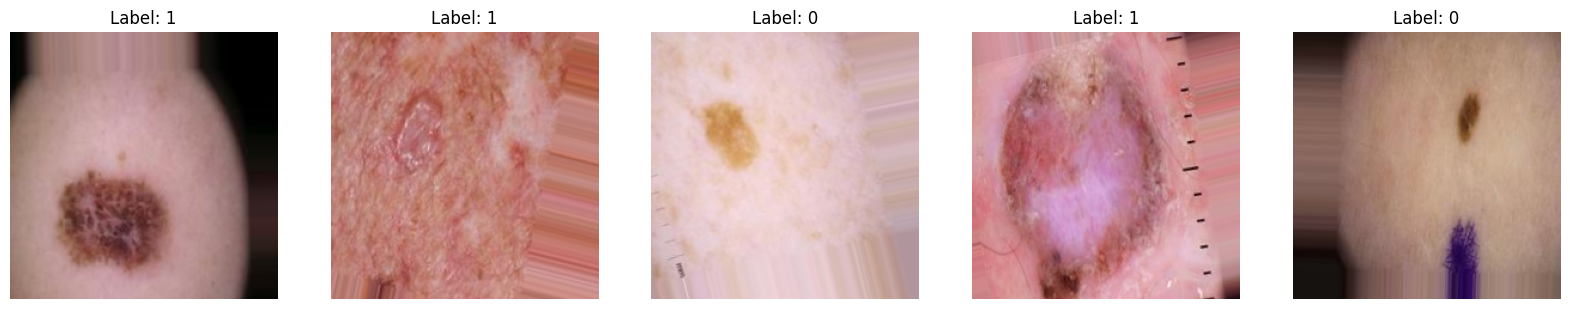

In [52]:
x_batch, y_batch = next(train_generator)

# Menampilkan beberapa gambar dari batch
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axes[i].imshow(x_batch[i])
    axes[i].axis('off')
    axes[i].set_title(f"Label: {np.argmax(y_batch[i])}")  # Menampilkan label kelas

plt.show()


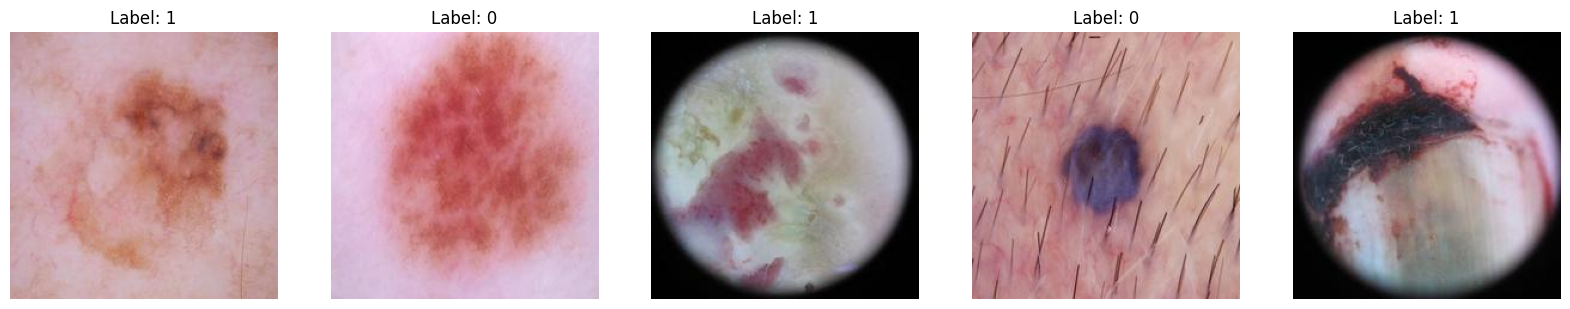

In [53]:
x_batch_val, y_batch_val = next(val_generator)  # atau next(test_generator)

# Menampilkan beberapa gambar dari batch validasi
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axes[i].imshow(x_batch_val[i])
    axes[i].axis('off')
    axes[i].set_title(f"Label: {np.argmax(y_batch_val[i])}")  # Menampilkan label kelas

plt.show()


#**Model Menggunakan Sequential, Conv2D, dan Pooling Layer**

In [35]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),  # Untuk mencegah overfitting
    Dense(3, activation="softmax")  # 3 kelas
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Periksa summary model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

# **Callback & Training**

In [13]:
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

callbacks = [lr_scheduler, early_stopping]

# Training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 1324s 4s/step - accuracy: 0.7023 - loss: 0.5637 - val_accuracy: 0.8374 - val_loss: 0.3878 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 1328s 4s/step - accuracy: 0.8112 - loss: 0.4130 - val_accuracy: 0.8374 - val_loss: 0.3761 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 1320s 4s/step - accuracy: 0.8359 - loss: 0.3747 - val_accuracy: 0.8610 - val_loss: 0.3296 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 1315s 4s/step - accuracy: 0.8323 - loss: 0.3676 - val_accuracy: 0.8635 - val_loss: 0.3163 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 1305s 4s/step - accuracy: 0.8480 - loss: 0.3434 - val_accuracy: 0.8458 - val_loss: 0.3508 - learning_rate: 1.0000e-04


#**Evaluasi Model**

38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 966ms/step - accuracy: 0.8472 - loss: 0.3672

Test Accuracy: 86.80%
Test Loss: 0.3292


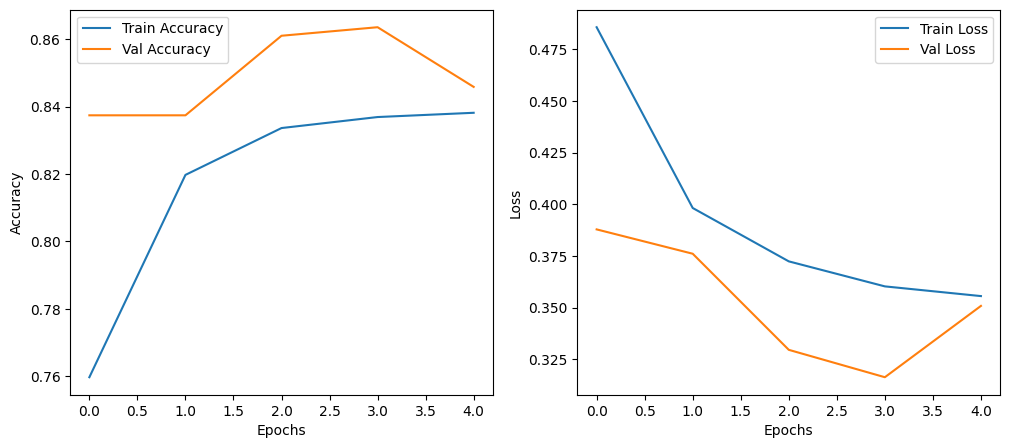

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Plot akurasi dan loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


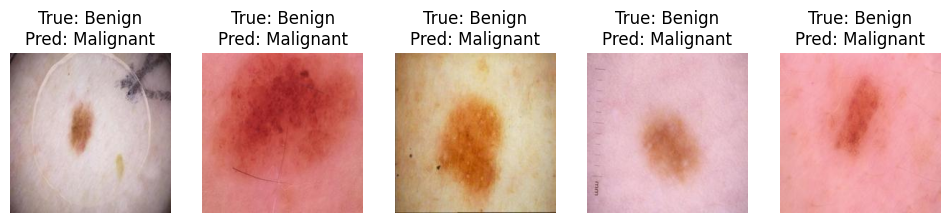

In [56]:
def display_random_images_from_directory(directory, class_names, num_images=5):
    # Ambil gambar acak
    images = []
    labels = []

    for class_name in class_names:
        class_folder = f"{directory}/{class_name}"
        image_files = os.listdir(class_folder)

        random_images = np.random.choice(image_files, num_images)
        for img_file in random_images:
            img_path = os.path.join(class_folder, img_file)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            images.append(img_array)
            labels.append(class_names.index(class_name))  # Menandakan kelas label

    # Gabungkan semua gambar ke dalam satu array
    images = np.vstack(images)
    labels = np.array(labels)

    # Prediksi dengan model
    predictions = model.predict(images)

    # Tampilkan gambar dan prediksi
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i] / 255.0)
        true_class = class_names[labels[i]]
        predicted_class = class_names[np.argmax(predictions[i])]
        plt.title(f"True: {true_class}\nPred: {predicted_class}")
        plt.axis('off')
    plt.show()

# Menampilkan gambar acak dari test set
class_names = ["Benign", "Malignant", "Normal"]
display_random_images_from_directory(test_dir, class_names, num_images=5)


#**Menyimpan Model ke Dalam Format SavedModel, TF-Lite dan TFJS**

In [43]:
import tensorflowjs as tfjs

# Tentukan direktori output untuk model TensorFlow.js
tfjs_model_dir = '/content/tfjs_model'

# Buat folder untuk menyimpan model TensorFlow.js jika belum ada
os.makedirs(tfjs_model_dir, exist_ok=True)

# Konversi model Keras ke format TensorFlow.js
tfjs.converters.save_keras_model(model, tfjs_model_dir)


failed to lookup keras version from the file,
    this is likely a weight only file


In [42]:
saved_model_dir = '/content/saved_model'

# Pastikan folder sudah ada
os.makedirs(saved_model_dir, exist_ok=True)

# Menyimpan model dalam format SavedModel
model.export(saved_model_dir)


Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136789916536272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136789916537808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136789916537232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136789916538576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136789916538000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136789916539344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136789916538768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136789916540112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136789916539536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136789916540880: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [19]:
import tensorflow as tf
from google.colab import files  # Tambahkan ini!

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Unduh model TFLite
files.download("model.tflite")

# Simpan dan unduh label kelas
labels = list(train_generator.class_indices.keys())
with open("label.txt", "w") as f:
    f.write("\n".join(labels))

files.download("label.txt")  # Unduh label

Saved artifact at '/tmp/tmpniun27as'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132036124698832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132036124699600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132036124699216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132036124702480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132036124701712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132036124703440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132036124702864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132036124703824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132036124704016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132036124704400: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Tulis requirements.txt
requirements = """
tensorflow==2.12.0
tensorflowjs==4.4.0
numpy==1.24.2
matplotlib==3.7.1
"""

# Simpan ke file requirements.txt
with open('/content/requirements.txt', 'w') as f:
    f.write(requirements)


In [47]:
import shutil
import os

# Tentukan direktori untuk setiap format
saved_model_dir = '/content/saved_model'
tfjs_model_dir = '/content/tfjs_model'
requirements_file = '/content/requirements.txt'

# Tentukan nama file zip output
zip_filename = '/content/submission.zip'

# Buat folder sementara untuk file yang akan dimasukkan ke dalam zip
submission_dir = '/content/submission'

# Hapus folder submission jika sudah ada sebelumnya
if os.path.exists(submission_dir):
    shutil.rmtree(submission_dir)

# Buat folder submission baru
os.makedirs(submission_dir, exist_ok=True)

# Salin file dan folder yang diperlukan ke folder submission
# Menyalin SavedModel
shutil.copytree(saved_model_dir, os.path.join(submission_dir, 'saved_model'))

# Menyalin model TFJS
shutil.copytree(tfjs_model_dir, os.path.join(submission_dir, 'tfjs_model'))

# Menyalin requirements.txt
shutil.copy(requirements_file, os.path.join(submission_dir, 'requirements.txt'))

# Membuat file zip dari folder submission
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', submission_dir)

# Hapus folder sementara
shutil.rmtree(submission_dir)

# Menyediakan link unduhan
from google.colab import files
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>